In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold



In [3]:
df_X = pd.read_csv('extract_train_Jul08.csv')
df_y = pd.read_csv('extract_label_Jul08.csv')

In [4]:
df_X = df_X[df_X.columns[1:]]

In [5]:
scaler = StandardScaler()
scaler.fit(df_X)
X = pd.DataFrame(scaler.transform(df_X), columns=df_X.columns)
y = df_y['target']

In [6]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [7]:
from sklearn.svm import SVR
from sklearn.feature_selection import RFE

In [8]:
def nn(X_train, y_train, X_val, y_val, X_test):
    model = Sequential()
    model.add(Dense(30, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1, activation='relu'))
   # model.add(Dense(1), W_regularizer=l2(0.01))
#     model.add(activation('softmax'))
    model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])
   
    model.fit(X_train.to_numpy(), y_train.to_numpy())

    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    return y_pred_val.flatten(), y_pred_test

In [9]:
def svm_regression(X_train, y_train, X_val, y_val, X_test):
    model = SVR(kernel='linear')
    selector = RFE(model, 3, step=1)
    selector = selector.fit(X_train.to_numpy(), y_train.to_numpy())
    model.fit(X_train.to_numpy(), y_train.to_numpy())
    
    y_pred_val = np.where(model.predict(X_val)<0,-1*model.predict(X_val),model.predict(X_val))
    y_pred_test = np.where(model.predict(X_test)<0,1*model.predict(X_test),model.predict(X_test))
    
    return y_pred_val.flatten(), y_pred_test, pd.Series(abs(model.coef_[0]), index=X_val.columns).to_numpy()


In [18]:
def svm_dimreduct(X_train, y_train, X_val, y_val, X_test):
    estimator = SVR(kernel='linear')
    selector = RFE(estimator, 3, step=1)
    selector = selector.fit(X_train.to_numpy(), y_train.to_numpy())
    
    
    cols = X_train.columns
    new_cols = []
    for i in range(len(selector.support_)):
        if selector.support_[i]:
            new_cols.append(cols[i])
            
    new_X_train = X_train[new_cols]
    new_X_val = X_val[new_cols]
    new_X_test = X_test[new_cols] 
    
    model = SVR(kernel='rbf')
    model.fit(new_X_train.to_numpy(), y_train.to_numpy())
    
    y_pred_val = model.predict(new_X_val)
    y_pred_test = model.predict(new_X_test)
    
    return y_pred_val.flatten(), y_pred_test

In [11]:
n_fold = 5
kfold = KFold(n_splits=n_fold, shuffle=True, random_state=1)

In [12]:
def K_fold_evaluation(X, y, X_test, func, classifier):
    y_pred_test_average, y_pred_train, scores = np.zeros(len(X_test)),np.zeros(len(y)), []
    feature_analysis = pd.DataFrame()
    
    print('%s classifier' %classifier)
    for ii, (train_idxes, val_indxes) in enumerate(kfold.split(X)):
        
        # Prepare the data
        X_train, X_val = X.iloc[train_idxes], X.iloc[val_indxes]
        y_train, y_val = y.iloc[train_idxes], y.iloc[val_indxes]
        
        # Fit the model and append score
        y_pred_val, y_pred_test, feature_importance = func(X_train, y_train, X_val, y_val, X_test)
        
        y_pred_train[val_indxes] = y_pred_val
        scores.append(mean_absolute_error(y_pred_val, y_val))
#         y_pred_test_average += y_pred_test
        print('KFold %d: val_score = %.2f' %(ii+1, scores[-1]))
        
        current_feature_analysis = pd.DataFrame()
        current_feature_analysis['features'] = X.columns
        current_feature_analysis['importance'] = feature_importance
        feature_analysis = pd.concat([feature_analysis, current_feature_analysis], axis=0)
    
    y_pred_test_average = y_pred_test_average/n_fold
    feature_analysis['importance'] = feature_analysis['importance']/feature_analysis['importance'].max()
    print('-----------------------------------------------------------')
    print('Complete K-Fold and Cross Validation for %s' %(classifier))
    print('Validation MeanAbsoluteError: Mean = %.3f Std = %.3f' %(np.mean(scores), np.std(scores)))
    
    plt.figure(figsize=(18,6))
    plt.subplot(121); sns.barplot(x = 'importance', y = 'features', data= feature_analysis)
    plt.title('Feature Importance')
    plt.subplot(122);plt.title('KFold prediction on training set')
    plt.plot(y_pred_train, linewidth = 3); plt.plot(y, linewidth = 2); 
    plt.xlabel('Index'); plt.ylabel('Time before Failure (s)'); plt.legend(['Pred', 'Actual']);
    
    return scores, y_pred_train, y_pred_test_average

In [13]:
def K_fold_evaluation1(X, y, X_test, func, classifier):
    y_pred_test_average, y_pred_train, scores = np.zeros(len(X_test)),np.zeros(len(y)), []
    feature_analysis = pd.DataFrame()
    
    print('%s classifier' %classifier)
    for ii, (train_idxes, val_indxes) in enumerate(kfold.split(X)):
        
        # Prepare the data
        X_train, X_val = X.iloc[train_idxes], X.iloc[val_indxes]
        y_train, y_val = y.iloc[train_idxes], y.iloc[val_indxes]
        
        # Fit the model and append score
        y_pred_val, y_pred_test = func(X_train, y_train, X_val, y_val, X_test)
        
        y_pred_train[val_indxes] = y_pred_val
        scores.append(mean_absolute_error(y_pred_val, y_val))
#         y_pred_test_average += y_pred_test
        print('KFold %d: val_score = %.2f' %(ii+1, scores[-1]))
        
#         current_feature_analysis = pd.DataFrame()
#         current_feature_analysis['features'] = X.columns
#         current_feature_analysis['importance'] = feature_importance
#         feature_analysis = pd.concat([feature_analysis, current_feature_analysis], axis=0)
    
    y_pred_test_average = y_pred_test_average/n_fold
#     feature_analysis['importance'] = feature_analysis['importance']/feature_analysis['importance'].max()
    print('-----------------------------------------------------------')
    print('Complete K-Fold and Cross Validation for %s' %(classifier))
    print('Validation MeanAbsoluteError: Mean = %.3f Std = %.3f' %(np.mean(scores), np.std(scores)))
    
    plt.figure(figsize=(18,6))
    plt.subplot(121); #sns.barplot(x = 'importance', y = 'features', data= feature_analysis)
    #plt.title('Feature Importance')
    plt.subplot(122);plt.title('KFold prediction on training set')
    plt.plot(y_pred_train, linewidth = 3); plt.plot(y, linewidth = 2); 
    plt.xlabel('Index'); plt.ylabel('Time before Failure (s)'); plt.legend(['Pred', 'Actual']);
    
    return scores, y_pred_train, y_pred_test_average

nn classifier
Epoch 1/1
3356/3356 [==============================] - 3s 760us/step - loss: 9.0927 - acc: 0.0000e+00
KFold 1: val_score = 2.12
Epoch 1/1
3356/3356 [==============================] - 2s 741us/step - loss: 9.7014 - acc: 0.0000e+00
KFold 2: val_score = 2.11
Epoch 1/1
3356/3356 [==============================] - 3s 767us/step - loss: 9.9657 - acc: 0.0000e+00
KFold 3: val_score = 2.10
Epoch 1/1
3356/3356 [==============================] - 3s 759us/step - loss: 11.0100 - acc: 0.0000e+00
KFold 4: val_score = 2.05
Epoch 1/1
3356/3356 [==============================] - 3s 763us/step - loss: 8.9510 - acc: 0.0000e+00
KFold 5: val_score = 2.07
-----------------------------------------------------------
Complete K-Fold and Cross Validation for nn
Validation MeanAbsoluteError: Mean = 2.090 Std = 0.025
CPU times: user 19.2 s, sys: 394 ms, total: 19.6 s
Wall time: 19.4 s


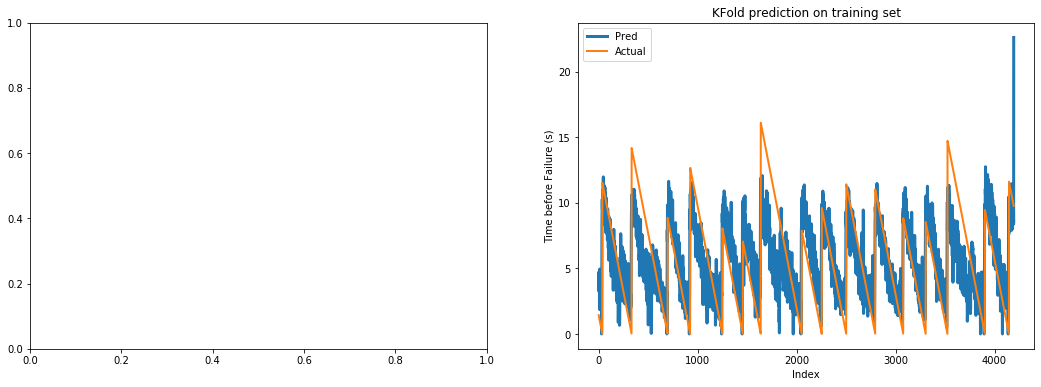

In [159]:
%%time
scores, y_pred_train, y_pred_test_average = K_fold_evaluation1(X[X.columns[1:]], y, X[X.columns[1:]], 
                                                                 nn,  'nn')

svm classifier
KFold 1: val_score = 2.10
KFold 2: val_score = 1.99
KFold 3: val_score = 2.08
KFold 4: val_score = 2.03
KFold 5: val_score = 2.06
-----------------------------------------------------------
Complete K-Fold and Cross Validation for svm
Validation MeanAbsoluteError: Mean = 2.054 Std = 0.039
CPU times: user 32.7 s, sys: 982 ms, total: 33.6 s
Wall time: 28.3 s


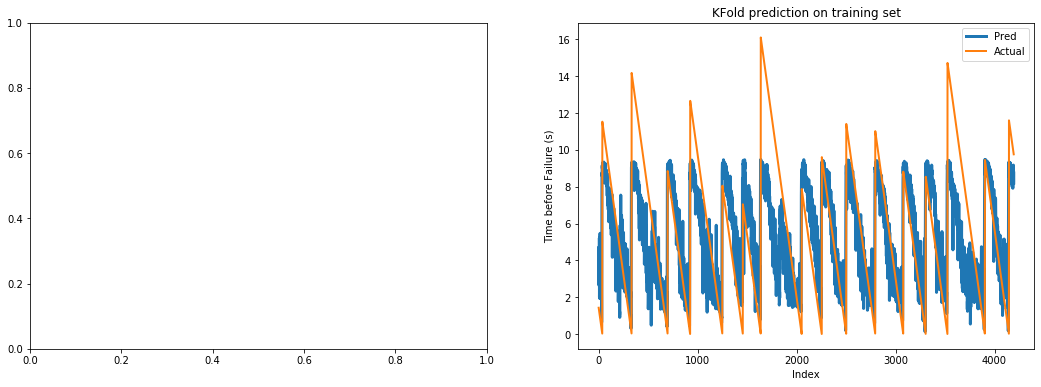

In [19]:
%%time
scores, y_pred_train, y_pred_test_average = K_fold_evaluation1(X[X.columns[1:]], y, X[X.columns[1:]], 
                                                                 svm_dimreduct,  'svm')

svm classifier
KFold 1: val_score = 2.13
KFold 2: val_score = 2.04
KFold 3: val_score = 2.13
KFold 4: val_score = 2.08
KFold 5: val_score = 2.11
-----------------------------------------------------------
Complete K-Fold and Cross Validation for svm
Validation MeanAbsoluteError: Mean = 2.099 Std = 0.037
CPU times: user 36.7 s, sys: 1.28 s, total: 37.9 s
Wall time: 32.2 s


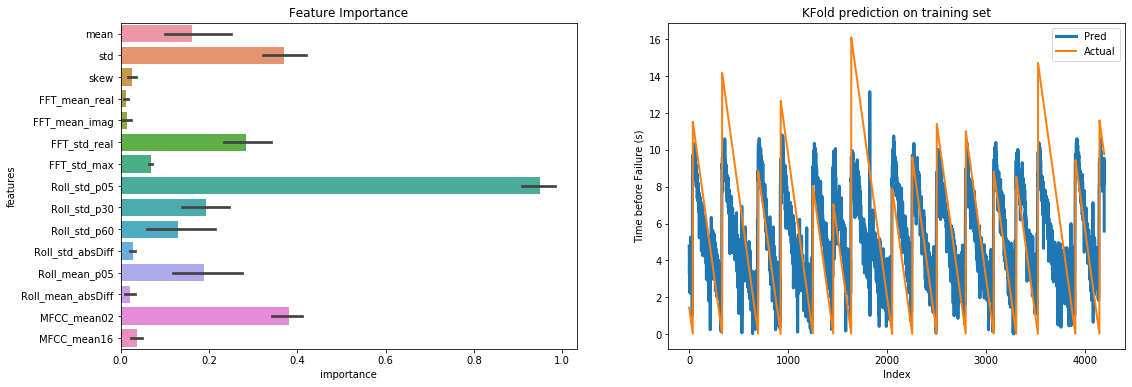

In [14]:
%%time
scores, y_pred_train, y_pred_test_average = K_fold_evaluation(X[X.columns[1:]], y, X[X.columns[1:]], 
                                                                 svm_regression,  'svm')